<center> <h1> Predicting lung cancer survival time </h1>  </center>
<center> <h6>by OWKIN</h6> </center>

Applicant: Chiekh ALLOUL

In [1]:
import os
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sksurv.metrics import concordance_index_censored
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import re
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv3D, MaxPooling3D, Reshape, SpatialDropout3D, Flatten, AveragePooling3D
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
import keras.backend as K
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from lifelines.utils import concordance_index

Using TensorFlow backend.


### Preliminaries

In [2]:
archive = np.load('train\images\patient_002.npz')
scan = archive['scan']
mask = archive['mask']
# scan.shape equals mask.shape

When freezing one dimension (any of the 3), we can use usual libraries to plot one slice of the CT scan.

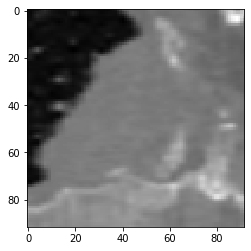

In [3]:
frozen = 60
plt.imshow(scan[:,frozen,:], cmap='gray')

This is done to have an understanding of the type of data we are dealing with.

### Importing data and feature-based ML

We can first import all features at once as we plan to merge *clinical_data.csv* and *radiomics.csv*

##### Datasets

In [4]:
# importing radiomics
names = pd.read_csv('train/features/radiomics.csv', header=1, nrows=1).columns
X_radiomics = pd.read_csv('train/features/radiomics.csv', header=2, names=names)
X_radiomics = X_radiomics.rename(columns={'Unnamed: 0': 'PatientID'})

names_bis = pd.read_csv('test/features/radiomics.csv', header=1, nrows=1).columns
X_test_radiomics = pd.read_csv('test/features/radiomics.csv', header=2, names=names)
X_test_radiomics = X_test_radiomics.rename(columns={'Unnamed: 0': 'PatientID'})

# importing clinical_data
X_clinical_data = pd.read_csv('train/features/clinical_data.csv')
X_test_clinical_data = pd.read_csv('test/features/clinical_data.csv')

# importing y
y = pd.read_csv('train/features/y_train.csv')
y['Event'] = y['Event'].apply(lambda x: bool(x))

col1 = y['Event']
col2 = y['SurvivalTime']
df = pd.concat([col1, col2], axis = 1)
y_tuple = (np.asarray(df.to_records(index=False)))


X = X_radiomics.merge(X_clinical_data, left_on='PatientID', right_on='PatientID')
X_test = X_test_radiomics.merge(X_test_clinical_data, left_on='PatientID', right_on='PatientID')

Let's plot an histogram of survival among patients. We will use this to design a binary or multiclass classification problem so that we can properly train a 3D CNN network. The idea is to consider some layers as additional features.

(array([108.,  73.,  47.,  27.,  29.,  11.,   0.,   5.]),
 array([  14.  ,  449.75,  885.5 , 1321.25, 1757.  , 2192.75, 2628.5 ,
        3064.25, 3500.  ]),
 <a list of 8 Patch objects>)

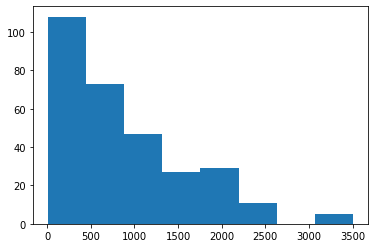

In [5]:
plt.hist(y['SurvivalTime'], bins = 8)

In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=3)
indice = next(kf.split(X))
train, validation = indice
X_train, y_train = X.iloc[train], y.iloc[train]
X_validation, y_validation = X.iloc[validation], y.iloc[validation]

We randomly split our dataset into train and validation sets. This allows us not to have a score that is too optimistic or biased and avoid overfitting. We have used these to create our model but they are not featured in this final report.

##### CNN-based features

Now that we have our first features, we would like to run CNN models in order to create other features in an unsupervised way from our dataset, making our model more efficient and robust. The first idea was to run a simple CNN Network, getting inspiration from existing papers (see below). Because CNNs are quite inefficient for regressions, we can create classes that represent survival intervals. We split our dataset into three quantiles and we want to predict to which quantile each patient belongs. This is a 3-class classification problem.

After running some tests, best results were obtained by only considering tumor areas. This also makes our model more robust. Indeed given the lack of data, having only 300 92x92x92 is not sufficient to train a network that would correctly discriminate images of this size. We only consider tumor areas by multiplying each CT-scan image by its respective mask.

In [47]:
### Extracting CT-scans from the dataset
CT_scan = []
mask_arr = []
IDs = []

def normalize_CT(scan):
    scan = scan - np.mean(scan)
    scan /= np.std(scan)
    return scan
    
for ctscan in os.listdir('train\\images'):
    filename = 'train\\images\\{}'.format(ctscan)
    archive = np.load(filename)
    ## Get the ID from the filename
    ID = int(re.findall(r'\d+', filename)[0])
    scan = archive['scan']
    mask = archive['mask']
    input_ = np.multiply(normalize_CT(scan), mask)
    CT_scan.append(input_)
    mask_arr.append(mask)
    IDs.append(ID)

CT_scan = np.expand_dims(np.array(CT_scan), 4)
CNN_order = pd.merge(pd.DataFrame(IDs, columns=['PatientID']), y,how='outer', on = 'PatientID')[['PatientID','SurvivalTime']]
CT_scan_train, CNN_order_train = CT_scan[train], CNN_order.iloc[train]
CT_scan_validation, CNN_order_validation = CT_scan[validation], CNN_order.iloc[validation]

In [48]:
### Extracting CT-scans from the test set
CT_scan_test = []
mask_arr_test = []
ID_test = []
    
for ctscan in os.listdir('test\\images'):
    filename = 'test\\images\\{}'.format(ctscan)
    archive = np.load(filename)
    ## Get the ID from the filename
    ID = int(re.findall(r'\d+', filename)[0])
    scan = archive['scan']
    mask = archive['mask']
    input_ = np.multiply(normalize_CT(scan), mask)
    CT_scan_test.append(input_)
    mask_arr_test.append(mask)
    ID_test.append(ID)

CT_scan_test = np.expand_dims(np.array(CT_scan_test), 4)
CNN_order_test = pd.DataFrame(ID_test, columns=['PatientID'])

##### Create a 3-class problem

We create intervals based on quantiles from our existing dataset to create 3-class classification problem

In [49]:
# We retrieve the intervals and don't forget to include the maximum value
intervals = CNN_order['SurvivalTime'].quantile([0,0.33,0.66,1]).values
intervals[-1] += 1

survival_time_class = pd.cut(CNN_order['SurvivalTime'], bins=intervals, right=False, labels=np.arange(len(intervals)-1))
# One-hot encoding
CT_target = to_categorical(survival_time_class.to_numpy())
CT_target_train, CT_target_validation = CT_target[train], CT_target[validation]

This simple model is inspired from one paper dealing with convolution-based networks with CT-scans (see below)

In [50]:
model = Sequential([
    Conv3D(10,(3,3,3), strides=(1, 1, 1), input_shape=(92, 92, 92, 1)),
    MaxPooling3D((2,2,2)),
    Conv3D(10, (3,3,3)),
    MaxPooling3D((2,2,2)),
    Flatten(),
    Dense(500),
    Activation('relu'),
    Dense(10),
    Activation('tanh'),
    Dense(2),
    Activation('sigmoid'),
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 90, 90, 90, 10)    280       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 45, 45, 45, 10)    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 43, 43, 43, 10)    2710      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 21, 21, 21, 10)    0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 92610)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               46305500  
_________________________________________________________________
activation_4 (Activation)    (None, 500)              

In [51]:
# ### Fitting is done on Google Colab, we included a validation split to make our model relevant
model.load_weights('my_model_new_weights.h5')

### We retrieve the features from the CNN network (10 features)
layer_name = 'dense_5'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(CT_scan)

### We create the columns that will contain the CNN-based features
columns_CNN = ["CNN "+str(i) for i in range(intermediate_output.shape[1])]
CNN_features = pd.concat([CNN_order['PatientID'],
                                pd.DataFrame(intermediate_output, columns = columns_CNN)], axis = 1)

new_X = X.merge(CNN_features, how='outer', on = 'PatientID')

We therefore add 10 features that are CNN-based and should be helpful when predicting survival time.

In [52]:
### Extracting features test
intermediate_output_pred = intermediate_layer_model.predict(CT_scan_test)
CNN_features_test = pd.concat([CNN_order_test['PatientID'], pd.DataFrame(intermediate_output_pred, columns=columns_CNN)], axis = 1)
new_X_test = pd.merge(X_test, CNN_features_test, how='outer', on = 'PatientID')

We created a CNN-based model and made sure to include a validation set here! However, we have to notice that including features from this CNN is heavily biased. Indeed:
- The CNN easily overfits given that we have a very small set, only 300 images
- By extracting features from a CNN model trained on the whole dataset, we have an information leakage, making cross-validation with our Gradient Boosting Survival Analysis less relevant

We decide to do it anyway because using these additional features help have more insights but we keep these points in mind.

In [53]:
new_X_test

,PatientID,original_shape_Compactness1,original_shape_Compactness2,original_shape_Maximum3DDiameter,original_shape_SphericalDisproportion,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume,original_firstorder_Energy,...,CNN 0,CNN 1,CNN 2,CNN 3,CNN 4,CNN 5,CNN 6,CNN 7,CNN 8,CNN 9
0,13,0.028885,0.296451,106.901824,1.499738,0.666783,29085.541425,0.114528,254069.0,2.006942e+09,...,-31.469465,30.733435,69.776848,44.600853,32.255478,77.187172,138.775345,-60.360825,37.226151,-13.097344
1,155,0.031948,0.362660,18.814888,1.402276,0.713126,629.443640,0.703879,911.0,2.623938e+08,...,1.908881,4.193396,-2.068540,-0.274834,-1.323626,-3.868913,-2.942106,0.317890,-3.933832,2.407646
2,404,0.015999,0.090945,105.080921,2.223687,0.449704,12509.265444,0.315298,39809.0,6.650322e+08,...,1.236241,2.404723,-0.831974,0.585010,-0.076867,-2.292927,-1.959457,0.465241,-1.285246,1.614252
3,407,0.031358,0.349373,46.968074,1.419832,0.704309,4067.657372,0.282104,14458.0,3.754287e+08,...,4.026303,19.176197,-1.517345,-0.753691,-6.160918,-6.767896,5.525041,-0.977531,-15.952967,7.370789
4,9,0.017815,0.112759,56.542020,2.069901,0.483115,7093.365690,0.376032,18942.0,9.108915e+09,...,7.020765,38.558311,-20.702675,-4.052834,-9.618299,-25.796795,-7.398881,-0.876263,-15.866465,13.000001
5,49,0.038162,0.517446,20.124612,1.245599,0.802826,844.234449,0.508818,1676.0,3.257278e+08,...,2.585248,6.726836,-3.237670,-1.177220,-2.939922,-5.486904,-3.744990,-0.860303,-7.092981,3.181355
6,55,0.036999,0.486382,19.824228,1.271572,0.786428,761.954649,0.552425,1395.0,2.594363e+08,...,2.393153,5.980139,-2.801389,-0.875912,-2.523019,-5.096919,-3.283655,-0.494523,-6.403327,3.141477
7,200,0.033738,0.404423,41.821047,1.352243,0.739512,4293.649006,0.255208,16863.0,7.877604e+08,...,4.796605,45.713821,2.566726,2.384259,-17.320820,-22.277948,34.720161,-24.983398,-63.862328,17.188793
8,170,0.019293,0.132257,74.605630,1.962732,0.509494,11161.094041,0.276799,40405.0,2.215244e+09,...,-1.883763,62.475651,34.168148,4.485582,7.211485,29.667801,76.543266,-30.249760,-29.396843,5.599893
9,387,0.025315,0.227692,120.577776,1.637636,0.610636,26262.656709,0.137525,191071.0,1.794313e+09,...,-28.009993,32.183891,97.432037,39.700294,43.912117,104.244308,188.095383,-91.415741,14.477793,-22.472919


##### Preprocessing step

We clean the dataset, that comes with imputing missing values and scaling numerical values.

In [54]:
numerical_features = [c for c in new_X if new_X[c].dtype.kind in ('i', 'f')]
categorical_features = [c for c in new_X if new_X[c].dtype.kind not in ('i', 'f')]

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='error', drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

### Model

We have defined a custom cross validation scheme in order to assess each model produced with our reference metric. Furthermore, we create a custom score function to be able use GridSearch efficiently.

In [55]:
def custom_cross_validation(clf, X, target, cv=4, model=False):
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    col1 = target['Event']
    col2 = target['SurvivalTime']
    df = pd.concat([col1, col2], axis = 1)
    y = (np.asarray(df.to_records(index=False)))
    scores = []
    for train_index, test_index in kf.split(X):
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = concordance_index(col2.values[test_index], y_pred, col1.values.astype('int64')[test_index])
        scores.append(score)
    if model:
        return scores, clf
    return scores

def custom_score(y_true, y_pred):
    event = np.array([c[0] for c in y_true])
    survival_time = np.array([c[1] for c in y_true])
    score = concordance_index(survival_time, y_pred, event)
    return score

from sklearn.metrics import make_scorer
c = make_scorer(custom_score, greater_is_better=True)

In [56]:
clf_2 = GradientBoostingSurvivalAnalysis(loss='squared', learning_rate=0.1, n_estimators=100,
                                         criterion='friedman_mse', min_samples_split=2, min_samples_leaf=3,
                                         min_weight_fraction_leaf=0.25, max_depth=1, random_state = 2)

In [58]:
# np.mean(custom_cross_validation(clf_2, X, y, cv=4, model=False))

In [60]:
pipeline = Pipeline(steps=[
    ('imputer', preprocessor), ('clf', clf_2)])

parameters =   {'clf__learning_rate':np.arange(0.2, 0.4, 0.05), 'clf__n_estimators': np.arange(20,160,20),
                'clf__min_samples_split': np.arange(2,4), 'clf__min_samples_leaf':np.arange(1,3), 'clf__max_depth': [1, 2],
                'clf__subsample': np.arange(0.9, 1, 0.01)}

clf_ = GridSearchCV(pipeline, parameters, scoring=c, cv=KFold(n_splits=5, random_state=2), verbose=False)
clf_.fit(new_X, y_tuple)

GridSearchCV(cv=KFold(n_splits=5, random_state=2, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('imputer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                

In [65]:
clf_.best_params_

{'clf__learning_rate': 0.35,
 'clf__max_depth': 1,
 'clf__min_samples_leaf': 1,
 'clf__min_samples_split': 2,
 'clf__n_estimators': 20,
 'clf__subsample': 0.9700000000000001}

##### Submission

In [64]:
submission = pd.read_csv("random_submission_0vhlEZN.csv")
submission = submission.set_index('PatientID')

y_pred = clf_.predict(new_X_test)
submission['SurvivalTime'] = y_pred
submission.to_csv("submission_test.csv", na_rep = "nan")
submission.head(10)

,SurvivalTime,Event
PatientID,,
13,390.457153,NaN
155,785.120654,NaN
404,508.032632,NaN
407,484.929763,NaN
9,1416.704545,NaN
49,660.810108,NaN
55,660.810108,NaN
200,526.144633,NaN
170,430.354736,NaN


##### Next steps

- Explore different data augmentation methods would make our model more relevant but 3D augmentation is not natively supported by Keras, it would have taken too much time to create these custom functions. Transformations could be rotations, translations, cropping but also non-isometric transformations in order to create a bigger dataset. However we can notice that only doing rotations would already multiply by 6 the size of our dataset.
- I only took into account tumor areas but it might be worth considering the whole image if we have enough data in order to derive insights from areas outside of the tumor.
- We could also have considered over 100 CNN-based features and then run autoencoders in other to reduce dimensionality. This might have been super relevant as the clinical features are thought to be biased. However this implies that we would need to think a little bit more about which sub-problem we consider for the CNN network. Creating intervals based on quantiles for a multiclass problem might not be the best approach.

##### References
- *3D Deep Learning for Efficient and Robust Landmark Detection in Volumetric Data*, Yefeng Zheng, David Liu, Bogdan Georgescu, Hien Nguyen, and Dorin Comaniciu
- *A Scalable Discrete-Time Survival Model for Neural Networks*, Gensheimer, M. F. & Narasimhan, B. 
- *Image-based survival prediction for lung cancer patients using CNNs*, Philippe Weitz , Oliver Rippel, Dorit Merhof Institute of Imaging and Computer Vision, RWTH Aachen University, Germany
- *Classification of CT brain images based on deep learning networks* Xiaohong W. Gao a, Rui Hui b, Zengmin Tian b
- *A 3D Probabilistic Deep Learning System for Detection and Diagnosis of Lung Cancer Using Low-Dose CT Scans* Onur Ozdemir, Member, IEEE, Rebecca L. Russell, and Andrew A. Berlin, Member, IEEE
- *SurvivalNet: predicting patient survival from diffusion weighted magnetic resonance images using cascaded fully convolutional and 3D convolutional neural networks*